## Calculate effective diffusivity using atmospheric PV
**21 March 2022 by MiniUFO**

---
[TOC]

---
### 1. Introduction
In geophysical fluid, tracers are advected following the motion of the fluid partiles.  As a result, tracer contours are deformed, stretched, or even broken by differential advection.  In the case of a pure adiabatic case, a conservative tracer contour can be used as a fluid container, in which fluid mass cannot go through its border.  Contours can also be used as a coordinate for interesting analyses.

Here we would like to calculate the effective diffusivity proposed by [Nakamura (1996)](https://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281996%29053%3C1524%3ATDMEFA%3E2.0.CO%3B2), defined in a contour-based meridional coordinate **equivalent latitude**.  Basically, we need to tranform a 2D horizontal coordinates into a contour-based coordinate spanning the range (from min value to max value) of a tracer field.  This is equivalent to sorting the PV field in the meridional direction into a monotonic increasing PV profile.

The whole calculation is based on [xcontour](https://github.com/miniufo/xcontour).  It will show that the whole calculation procedure is very clean and clear.

---

### 2. Theoretical guide
The normalized (by molecular diffusivity) effective diffusivity, or the Nusselt number, for a quasi-conservative tracer $q$ is defined as:
$$K_{eff}=\frac{L_{eq}^2}{L_{min}^2}=\frac{\frac{\partial}{\partial A}\int_{q<q^*} |\nabla q^*|^2 dS}{L_{min}^2\left(\frac{\partial q}{\partial A}\right)^2}=\frac{<|\nabla q^*|^2>_q}{\left(\frac{\partial q}{\partial Y}\right)^2} \tag{1}$$

where $A$ is the area enclosed by tracer contours $q$, $<\cdot>_q$ is the along-contour average operator and $L_{min}$ is the minimum possible length of a q-contour (e.g., latitudinal circle).  Note that $\partial A=L_{min}\partial Y$.  One may find more specific details in [this book chapter of Nakamura (2008)](http://geosci.uchicago.edu/~nnn/Book_Nakamura_PrintPDF.pdf).

---

### 3. Calculation procedure
#### 3.1 Load data
Here for demonstrating purpose, we use potential vorticity (PV) as the conservative tracer $q$ in Eq. (1).  The data are downloaded from [ERA Interim (ECMWF)](https://apps.ecmwf.int/datasets/data/interim-full-daily/levtype=pt/) on isentropic levels.  Also, the squared PV gradient $|\nabla q|^2$ is pre-calculated along with the PV data.

First, we read in all the PV data at each isentropic levels:

In [1]:
import xarray as xr
import numpy as np
import sys
sys.path.append('../../')
from xcontour.xcontour import Contour2D, latitude_lengths_at, add_latlon_metrics

dset = xr.open_dataset('../Data/PV.nc')

print(dset)

# add metrics for xgcm.Grid
dset, grid = add_latlon_metrics(dset)

# get PV as a tracer and its squared gradient
tracer = dset.pv
grdS = dset.grdSpv

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, level: 15)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 ... 88.5 89.25 90.0
  * level      (level) int32 265 275 285 300 315 330 ... 430 475 530 600 700 850
    time       datetime64[ns] ...
Data variables:
    pv         (level, latitude, longitude) float32 ...
    grdSpv     (level, latitude, longitude) float32 ...
Attributes:
    units:      K m**2 kg**-1 s**-1
    long_name:  Potential vorticity


The PV data extends from 265K near the ground to 850K in the stratosphere and covers only one time snapshot on 01 Jan 2010.  We step up 121 contours on each isentropic levels in a linear fashion from minimum to maximum values.

In [2]:
# Initialize equally-spaced contours from minimum value to maximum
# value (within lat/lon dims).  Here will implicitly loop over each isentropic level
%matplotlib inline
N  = 121           # increase the contour number may get non-monotonic A(q) relation
increase = True    # Y-index increases with latitude (sometimes not)
lt = True          # northward of PV contours (larger than) is inside the contour
                   # change this should not change the result of Keff, but may alter
                   # the values at boundaries
dtype = np.float32 # use float32 to save memory
undef = -9.99e8    # for maskout topography if present

# initialize a Contour2D analysis class using grid and tracer
analysis = Contour2D(grid, tracer,
                     dims={'X':'longitude','Y':'latitude'},
                     dimEq={'Y':'latitude'},
                     increase=increase,
                     lt=lt)
# evenly-spaced contours
ctr = analysis.cal_contours(N)

# Mask for A(q) relation table.
# This can be done analytically in simple case, but we choose to do it
# numerically in case there are undefined values (topography) inside the domain.
mask = xr.where(tracer!=undef, 1, 0).astype(dtype)

print(ctr)

<xarray.DataArray 'pv' (level: 15, contour: 121)>
array([[-4.34436952e-05, -4.15529321e-05, -3.96621690e-05, ...,
         1.79666269e-04,  1.81557029e-04,  1.83447788e-04],
       [-3.12895281e-05, -2.95687532e-05, -2.78479802e-05, ...,
         1.71761829e-04,  1.73482593e-04,  1.75203371e-04],
       [-1.68830156e-05, -1.58910643e-05, -1.48991139e-05, ...,
         1.00167170e-04,  1.01159116e-04,  1.02151069e-04],
       ...,
       [-8.51756777e-05, -8.26942050e-05, -8.02127397e-05, ...,
         2.07637800e-04,  2.10119280e-04,  2.12600746e-04],
       [-1.42589153e-04, -1.37360956e-04, -1.32132773e-04, ...,
         4.74337576e-04,  4.79565788e-04,  4.84793971e-04],
       [-3.23796354e-04, -3.09809897e-04, -2.95823411e-04, ...,
         1.32660719e-03,  1.34059368e-03,  1.35458005e-03]], dtype=float32)
Coordinates:
  * level    (level) int32 265 275 285 300 315 330 ... 430 475 530 600 700 850
    time     datetime64[ns] 2010-01-01
  * contour  (contour) float32 0.0 1.0 2.0 3.0 

Now we can perform the calculation of effective diffusiviy.  Two sets of APIs are possible here.  First is based on `xarray`'s conditional integration.  This is very convenient for multi-dimensional calculation (here would implicitly loop over each isentropic level).  However, this would broadcast the 3D `DataArray(level, latitude, longitude)` to 4D `DataArray(level, latitude, longitude, contour)`, which is memory-consuming.

The second set of APIs is based on `xhistogram`'s box-counting method.  This is memory-friendly as there is no need to allocate 4D array.  But the implementation of xhistogram does not support multi-dimensional bins (time- or level-varying bins), we cannot use this set of API in the current case.

Here we can only use the first API set based on `xarray`'s conditional integration.  Be sure your memory is large enough for running this.  We also provide the second APE set and hope in the near future `xhistogram` support multi-dimensional bins well.

In [3]:
# calculate related quantities for Keff
# First set of APIs
# xarray's conditional integration, memory consuming and not preferred, for test only
table   = analysis.cal_area_eqCoord_table(mask) # A(Yeq) table
area    = analysis.cal_integral_within_contours(ctr).rename('intArea')
intgrdS = analysis.cal_integral_within_contours(ctr, integrand=grdS).rename('intgrdS')

# Second set of APIs
# xhistogram's box-counting, memory-friendly and preferred, but not here as contour bins vary with level
#table   = analysis.cal_area_eqCoord_table_hist(mask) # A(Yeq) table
#area    = analysis.cal_integral_within_contours_hist(ctr).rename('intArea')
#intgrdS = analysis.cal_integral_within_contours_hist(ctr, integrand=grdS).rename('intgrdS')

latEq   = table.lookup_coordinates(area).rename('latEq')
Lmin    = latitude_lengths_at(latEq).rename('Lmin')
dintSdA = analysis.cal_gradient_wrt_area(intgrdS, area).rename('dintSdA')
dqdA    = analysis.cal_gradient_wrt_area(ctr, area).rename('dqdA')
Leq2    = analysis.cal_sqared_equivalent_length(dintSdA, dqdA).rename('Leq2')
nkeff   = analysis.cal_normalized_Keff(Leq2, Lmin).rename('nkeff')

case 1: increase & lt


Now we can take a look at the normalized effective diffusivity `nkeff` in contour space as:

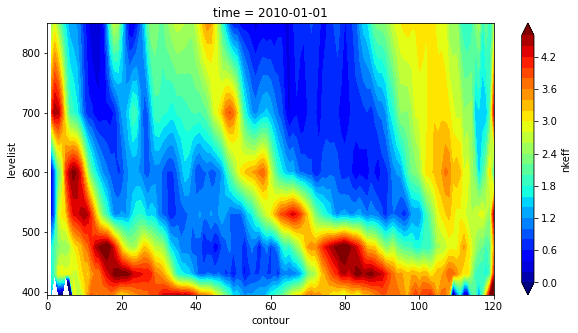

In [4]:
# Select those levels above ground (400k above)
np.log(nkeff[8:]).plot.contourf(figsize=(12, 6), cmap='jet', levels=np.linspace(0, 4.6, 24))

This is not so good because the results are defined on the evenly-distributed contour space, which is not evenly-distributed in latitude coordinates.  So we interpolate them onto regular equivalent latitudes as:

In [5]:
#%% combined the results
# results in contour space
ds_contour = xr.merge([ctr, area, intgrdS, latEq, dintSdA, dqdA, Leq2, Lmin, nkeff])

# interpolate from contour space to equivalent-latitude space
preLats = np.linspace(-90, 90, 181).astype(dtype)
# results in latEq space
ds_latEq = analysis.interp_to_dataset(preLats, latEq, ds_contour)

Text(0.5, 1.0, 'normalized effective diffusivity')

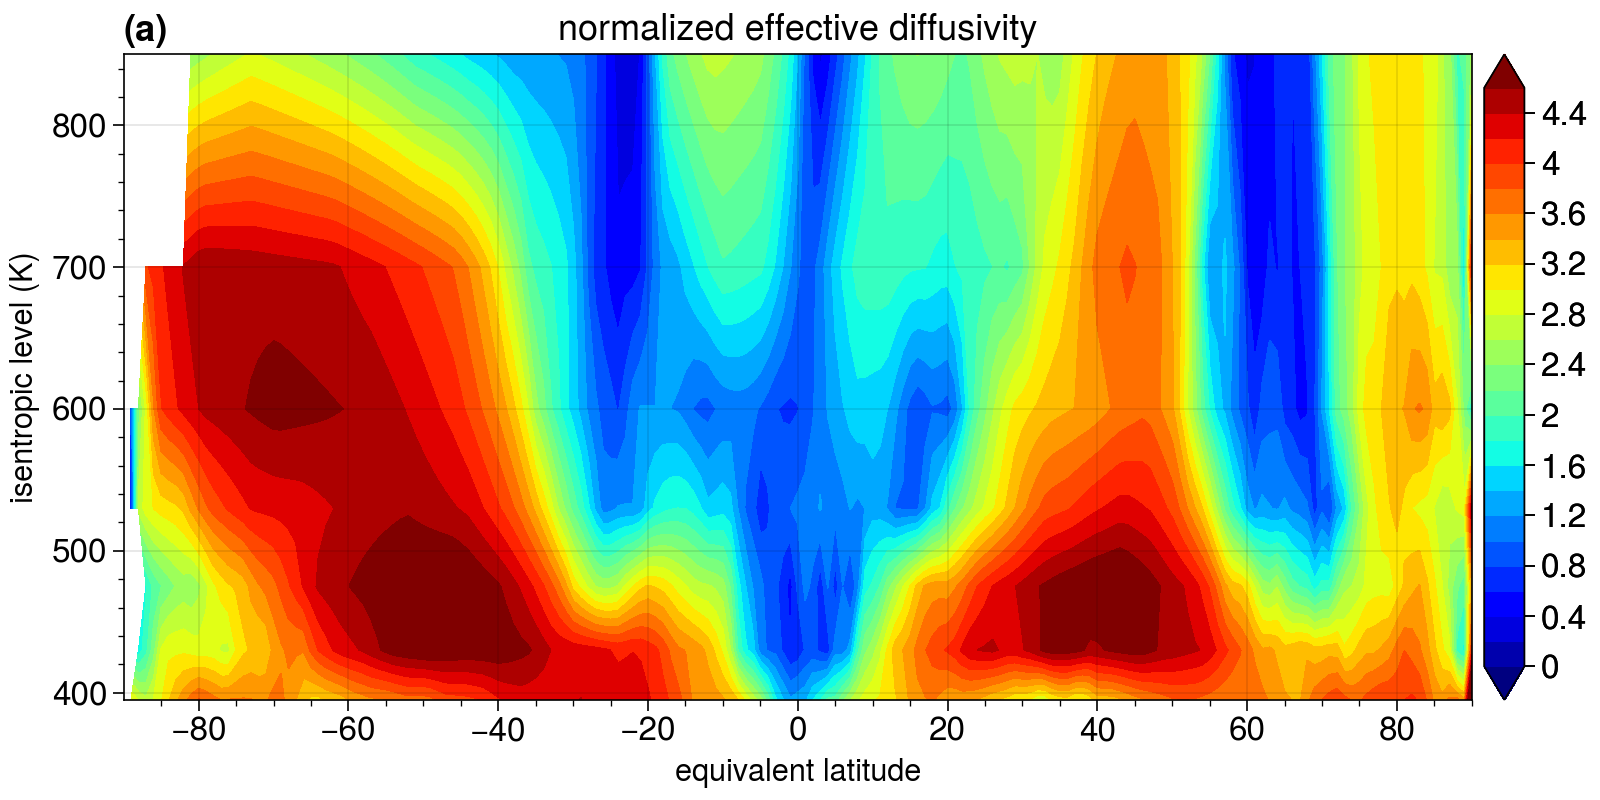

In [12]:
import proplot as pplt

# Plot effective diffusiviy again in equivalent latitude space
fontsize = 13

fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax = axes[0]
m=ax.contourf(np.log(ds_latEq.nkeff[8:]), cmap='jet', levels=np.linspace(0,4.6,24), extend='both')
ax.colorbar(m, loc='r', label='')
ax.set_xlabel('equivalent latitude', fontsize=fontsize-2)
ax.set_ylabel('isentropic level (K)', fontsize=fontsize-2)
ax.set_title('normalized effective diffusivity', fontsize=fontsize)

After some kind of stretch of the original figure, this looks much better now.  Two enhanced effective diffusivity bands can be clearly identified at midlatitudes, which is similar to the results in [Haynes and Shuckburgh (2000, JGR)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000JD900093).

#### References
1. Haynes, P., and E. Shuckburgh, 2000: [Effective diffusivity as a diagnostic of atmospheric transport 1. Stratosphere](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000JD900093). *J. Geophys. Res.*, **105**, 22777-22794.
2. Nakamura, N., 1996: [Two-dimensional mixing, edge formation, and permeability diagnosed in an area coordinate](https://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281996%29053%3C1524%3ATDMEFA%3E2.0.CO%3B2). *J. Atmos. Sci.*, **53**, 1524-1537.
3. Nakamura, N., 2008: [Quantifying inhomogeneous, instantaneous, irreversible transport using passive tracer field as a coordinate](http://geosci.uchicago.edu/~nnn/Book_Nakamura_PrintPDF.pdf). Transport and mixing in geophysical flows, J. B. Weiss, and A. Provenzale, Eds., Springer, 137-164.